# White Blood Cells -- Classification

## Dataset Description

The White Blood Cells dataset consists of 410 images, with 4 classes:  Eosinophil, Lymphocyte, Monocyte, and Neutrophil. Each of the images contains one White Blood Cells, surrounded by multiple red blood cells. The accompanying xml files contain bounding boxes for the segmentation of white blood cell images.

In [42]:
import csv
import numpy as np
import cv2
import glob, copy, os
import xml.etree.ElementTree
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.model_selection import KFold

### The Nature of the White Blood Cells Data

In the Blood Cell dataset, the raw data is images of multiple blood cells of size 640*480. For our classification purpose, we want to crop the exact white blood cell from each images. The Class of the White Cell does not depend on the context or the surrounding cells, so we crop the exact cell to reduce the data dimension.

For each of the images, the white blood cell is marked out by a corresponding .xml file. 

The label is given in a csv file, with a few entries left blank or having multiple classes. We eliminate these bad inputs and left with 356 valid data samples.

In [37]:

class Reading(object):
    """__init__() functions as the class constructor"""
    def __init__(self, xmin=None, ymin=None, xmax=None, ymax=None, typ=None, name=None):
        
        self.xmin = xmin
        self.xmax = xmax
        self.ymin = ymin
        self.ymax = ymax
        self.typ = typ
        self.name = name

docs = glob.glob('BCCD\\Annotations\\' + '*.xml')      

list_reading_arr = []
with open('labels.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    label_arr = []
    counter = 0
    for row in csv_reader:
        if counter != 0 and row[2] != "":
            label_arr.append([row[1], row[2]])
        counter += 1

index = 0
for i in range(len(docs)):
    if(int(label_arr[index][0]) == int(docs[i][-9:-4])):
        label_this = label_arr[index][1][0]
    else:
        if(int(label_arr[index-1][0]) == int(docs[i][-9:-4])):
            index += -1
            i+=-1
            label_this = label_arr[index][1][0]
        if(int(label_arr[index+1][0]) == int(docs[i][-9:-4])):
            label_this = label_arr[index+1][1][0]
            #i+=1
            index += 1
    
    if(label_this == 'B' or label_this == ''):
        index += 1
        continue
        
    tree = xml.etree.ElementTree.parse(docs[i])
    root = tree.getroot()
    len_data = int(len(tree.findall('.//object//'))/9)
    read = Reading()
    count = 0
    read.typ = label_this
    read.name = docs[i]
    for objs in tree.findall('.//object//'):

        index_of_reading = int(count/9)
        if count%9 == 0:
            if objs.text != "WBC":
                continue
        if count%9 == 5:
            read.xmin = int(objs.text)
        if count%9 == 6:
            read.ymin = int(objs.text)
        if count%9 == 7:
            read.xmax = int(objs.text)
        if count%9 == 8:
            read.ymax = int(objs.text)             
        
        count+=1
    list_reading_arr.append(read)
    for j in list_reading_arr:
        if j.xmax == j.xmin or j.ymax == j.ymin:
            list_reading_arr.remove(j)
    index += 1  

    

## data pre-processing -- image related


We want to generate a source matrix from the input images. After cropping the image, we resize all the cropped images and flatten each them into a vector. 

A discussion can be drawn when dealing with the channel of the image. The raw images are colored RGB images. Since some structures of the White cells are represented primarily by color, we can argue that preserving the RGB information can be beneficial for feature extraction. Our design is to offer choices of channels. We define the preprocessing stage into a function, and make color channel as an argument. We can use full RGB channel, or use 1 of 3 channels (only red pixels, or green, or blue), or use the converted Gray channel. Using full RGB channel will augment the dimensionality of the source matrix by factor of 3.

0.95 explained variance ratio can be achieved using at least 110 principle components


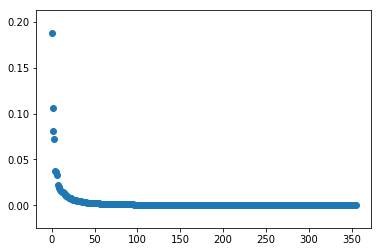

In [38]:
def crop_and_resize(img, read, size):
    w, h = size
    
    img_arr =[]
    xmin, ymin, xmax, ymax = (read.xmin,read.ymin,read.xmax,read.ymax)
    #print([xmin, ymin, xmax, ymax])
    img_crop = img[ymin:ymax,xmin:xmax]
    img_resized = cv2.resize(img_crop,(w, h), interpolation = cv2.INTER_CUBIC)
    img_arr.append(img_resized)

    return img_arr

def label_generator(read):
    if(read=='N'):
        return 0
    if(read=='M'):
        return 1
    if(read=='L'):
        return 2
    if(read=='E'):
        return 3
    
def recenter_regularize(X):
    X_mean = np.mean(X, axis = 1)[np.newaxis]
    X_centered = X - X_mean.T
    X_norm = np.linalg.norm(X_centered, axis = 1)[np.newaxis]
    X_normalized = X_centered/X_norm.T
    return X_normalized



path = 'BCCD\\JPEGImages\\'
#images = sorted(glob.glob(path + '*.jpg'))
WBC_arr_b = []; WBC_arr_g = []; WBC_arr_r = []; WBC_arr_gray = []
label_arr = []
#read images and make each into an array
for i in range(len(list_reading_arr)):
    img = path + os.path.split(list_reading_arr[i].name)[1][:-4] + '.jpg'
    WBC_this = cv2.imread(img)
    WBC_this_arr = crop_and_resize(WBC_this, list_reading_arr[i], (60,60))
    WBC_b = WBC_this_arr[0][:, :, 0]
    WBC_g = WBC_this_arr[0][:, :, 1]
    WBC_r = WBC_this_arr[0][:, :, 2]
    WBC_gray = cv2.cvtColor(WBC_this_arr[0], cv2.COLOR_BGR2GRAY)
    

    label = label_generator(list_reading_arr[i].typ)
    #print(label)

    WBC_b, WBC_g, WBC_r, WBC_gray = np.reshape(WBC_b, -1), np.reshape(WBC_g, -1), np.reshape(WBC_r, -1), np.reshape(WBC_gray, -1)
    
    
    WBC_arr_b.append(WBC_b)
    WBC_arr_g.append(WBC_g)
    WBC_arr_r.append(WBC_r)
    WBC_arr_gray.append(WBC_gray)
    label_arr.append(label)
        
        
    i+=1
    if(i==len(list_reading_arr)):
        break
WBC_arr_b, WBC_arr_g, WBC_arr_r, WBC_arr_gray = (np.asarray(WBC_arr_b).T, np.asarray(WBC_arr_g).T, 
                                                 np.asarray(WBC_arr_r).T, np.asarray(WBC_arr_gray).T)

(WBC_normalized_b, WBC_normalized_g, WBC_normalized_r, 
 WBC_normalized_gray) = (recenter_regularize(WBC_arr_b), recenter_regularize(WBC_arr_g),
                         recenter_regularize(WBC_arr_r), recenter_regularize(WBC_arr_gray)) 


U, S, V = np.linalg.svd(WBC_normalized_gray)

S_total = np.linalg.norm(S)**2
S_incr = 0
k = 0
for s in S:
    S_incr += s**2
    if(S_incr >= 0.95*S_total):
        break
    k += 1

print('0.95 explained variance ratio can be achieved using at least ' + str(k) + ' principle components')

fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(range(len(S)), S**2/S_total)
plt.show()


## data pre-processing PCA

In [32]:
pca = PCA(n_components = 10)
pca.fit(WBC_normalized_gray.T)
#print(pca.explained_variance_ratio_)
print(pca.components_.shape)


(10, 3600)


In [39]:
#Principle components
U_k = []
for i in range(k):
    U_k.append(U[:, i])
    
U_k = np.asarray(U_k)   
WBC_tilta_gray = []
for WBC in WBC_normalized_gray.T:
    WBC_tilta_gray.append(list(map(lambda x:np.inner(x, WBC), U_k.tolist())))
    



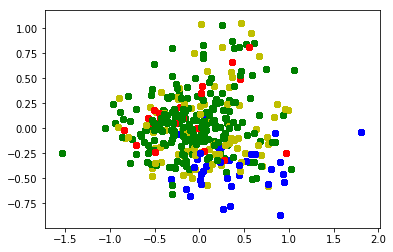

In [28]:
U_skPCA = pca.components_

U_skPCA = np.asarray(U_skPCA)
WBC_tilta_gray_sk = []

for WBC in WBC_normalized_gray.T:
    WBC_tilta_gray_sk.append(list(map(lambda x:np.inner(x, WBC), U_skPCA)))
    
fig = plt.figure()
ax = fig.add_subplot(111)
WBC_tilta_gray_sk = np.asarray(WBC_tilta_gray_sk)
counter = 0
for i in range(len(WBC_tilta_gray_sk)):
    if(label_arr[i] == 0):
        c = 'g'
    if(label_arr[i] == 1):
        c = 'r'
    if(label_arr[i] == 2):
        counter += 1
        c = 'b'
    if(label_arr[i] == 3):
        c = 'y'
        
    ax.scatter(WBC_tilta_gray_sk[i][0], WBC_tilta_gray_sk[i][1], color = c)

plt.show()

In [8]:
np.asarray(WBC_tilta_gray_sk).shape

(3600, 10)

In [20]:
U_k.shape

(110, 3600)

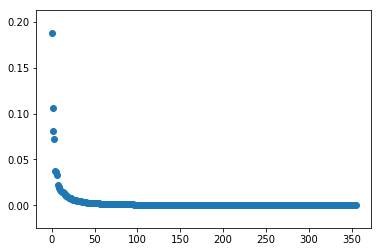

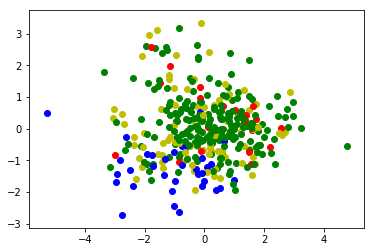

In [40]:
#RBC_tilta_list = copy.deepcopy(RBC_tilta)
WBC_tilta_gray = np.asarray(WBC_tilta_gray).T
WBC_tilta_gray_12 = WBC_tilta_gray[:2]



fig = plt.figure()
ax = fig.add_subplot(111)
WBC_tilta_gray_12 = WBC_tilta_gray_12.T
counter = 0
for i in range(len(WBC_tilta_gray_12)):
    if(label_arr[i] == 0):
        c = 'g'
    if(label_arr[i] == 1):
        c = 'r'
    if(label_arr[i] == 2):
        counter += 1
        c = 'b'
    if(label_arr[i] == 3):
        c = 'y'
        
    ax.scatter(WBC_tilta_gray_12[i][0], WBC_tilta_gray_12[i][1], color = c)

plt.show()


In [61]:
# KNN classifier
def KNN_classif(Feature, img_Rep, trainLabels, k):
    
    training_labels = np.asarray(trainLabels)
    #compute the distance of the input N-dim Feature to every other point
    #
    distance=[]
    for img in img_Rep.T:
        distance.append(np.linalg.norm(img - Feature))
    
    distance = np.array(distance)
    distance_k = distance.argsort()[:k]
    neighbors = training_labels[distance_k].tolist()
    #print(neighbors)
    #x = np.sum(training_labels[distance_k])
    #return x
    
    return max(neighbors, key=neighbors.count)
kf = KFold(n_splits = 5)
kf.get_n_splits(WBC_tilta_gray)

for train_index, test_index in kf.split(WBC_tilta_gray):
    print(test_index)
    WBC_tilta_train_gray, WBC_tilta_test_gray = WBC_tilta_gray[train_index], WBC_tilta_gray[test_index]
    label_train, label_test = np.asarray(label_arr)[train_index], np.asarray(label_arr)[test_index]
    cls = []
    for i in range(len(WBC_tilta_test_gray)):
    
        cls.append(KNN_classif(WBC_tilta_test_gray[:, i], WBC_tilta_train_gray , label_arr, 8))
    cls = np.asarray(cls)
    print(cls-label_test)
    
    
"""# k-fold Cross Validation 
cross_validation(samples, labels, k:int):
    m,n = np.shape(samples)
    samples_with_labels = np.row_stack((samples, labels))
    a = n//k
    fold = [0 for i in range(k)]
    for i in range(k):
        if i!= k-1:
            fold[i] = samples_with_labels[:, i*a:(i+1)*a]
        else:
            fold[i] = samples_with_labels[:, i*a:]
    
    reg_error = [0 for i in range(k)]
    labels_predict = []
    training_samples = []
    for i in range(k):
        
        test_samples = fold[i]
        training_samples.extend(fold[i])
        
WBC_tilta_gray_train = WBC_tilta_gray[:300, :].T
WBC_tilta_gray_test = WBC_tilta_gray[300:, :].T
cls = []

#for k in range()
for i in range(len(WBC_tilta_gray_test[0])):
print('here')
cls.append(KNN_classif(WBC_tilta_gray_test[:, i], WBC_tilta_gray_train , label_arr, 19))
"""







[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


ValueError: operands could not be broadcast together with shapes (88,) (22,) 

In [52]:
len(cls)

0